In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold,cross_val_score,StratifiedKFold
import statsmodels.formula.api as smf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from mlxtend.plotting import plot_learning_curves

from sklearn.linear_model import LinearRegression

In [2]:
# Get local path of data
path = os.path.abspath(os.getcwd())
path = os.path.abspath(os.path.join(path, os.pardir)) + '\\airbnb-listings.json'
path

'c:\\Users\\HP\\Desktop\\Data Analyst\\Projects\\airbnb-listings.json'

In [3]:
df = pd.read_json(path)

In [4]:
x =df['fields']
rows = len(x)
facets = ['id',
 'latitude',
 'longitude',
 'name',
 'host_id',
 'host_name',
 'host_response_time',
 'host_response_rate',
 'city',
 'country',
 'property_type',
 'room_type',
 'bed_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'extra_people',
 'price',
 'cancellation_policy',
 'minimum_nights',
 'maximum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'review_scores_value',
 'review_scores_cleanliness',
 'review_scores_accuracy',
 'calculated_host_listings_count',
 'amenities',
 'host_url']

In [5]:
x_records = []
for row in range(0,rows):
      data = x[row]
      x_records.append(data)

for ele in x_records:
    for f in facets:
        if f not in ele.keys():
            ele[f] = None

df2 = pd.DataFrame(x_records,columns=facets)
df2

,id,latitude,longitude,name,host_id,host_name,host_response_time,host_response_rate,city,country,...,minimum_nights,maximum_nights,number_of_reviews,reviews_per_month,review_scores_value,review_scores_cleanliness,review_scores_accuracy,calculated_host_listings_count,amenities,host_url
0,4008728,52.36523660409065,4.878249575101092,"Luxurious 3 bedroom, centrum, 180m2",20786453,Lithal,within a day,50.0,Amsterdam,Netherlands,...,2.0,1125.0,31.0,1.52,9.0,8.0,9.0,1.0,"TV,Internet,Wireless Internet,Kitchen,Pets all...",https://www.airbnb.com/users/show/20786453
1,7778612,52.367309030897516,4.8738407410699915,Luxury apartment in city centre,11964927,Hein,within a few hours,100.0,Amsterdam,Netherlands,...,2.0,1125.0,15.0,0.81,9.0,9.0,9.0,1.0,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",https://www.airbnb.com/users/show/11964927
2,8264596,52.361943953804776,4.866686522141489,Cosy apartment across Vondelpark,23669273,Matthieu,None,NaN,Amsterdam,Netherlands,...,4.0,1125.0,1.0,0.05,10.0,10.0,10.0,1.0,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",https://www.airbnb.com/users/show/23669273
3,2180729,52.37014616115532,4.866281767968382,Spacious City Apartment Oud-West,9238680,Bas,within a day,100.0,Amsterdam,Netherlands,...,3.0,30.0,22.0,0.62,9.0,9.0,10.0,1.0,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",https://www.airbnb.com/users/show/9238680
4,14463171,52.368817829014425,4.871249476925455,Cosy Studio Apartment Center Amsterdam,89112644,Pablo,within a day,100.0,Amsterdam,Netherlands,...,2.0,1125.0,16.0,2.04,9.0,8.0,8.0,1.0,"TV,Wireless Internet,Kitchen,Heating,Smoke det...",https://www.airbnb.com/users/show/89112644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494949,1150181,52.41823277406404,13.724483982850774,rlaub im grünen Umland von Berlin,6304086,Mechthild,None,NaN,Berlin,Germany,...,1.0,5.0,0.0,NaN,NaN,NaN,NaN,1.0,None,https://www.airbnb.com/users/show/6304086
494950,8699527,52.52811601427975,13.46193763388039,Big bright room in a good location for tavellers,2989041,Nikita,within an hour,100.0,Berlin,Germany,...,4.0,1125.0,6.0,0.54,9.0,9.0,10.0,1.0,"Internet,Wireless Internet,Kitchen,Smoking all...",https://www.airbnb.com/users/show/2989041
494951,16881873,52.523728272656875,13.474912706162689,Room for rent,91183137,Muhammad,within a day,100.0,Berlin,Germany,...,1.0,1125.0,1.0,0.35,8.0,10.0,10.0,1.0,"Smoking allowed,translation missing: en.hostin...",https://www.airbnb.com/users/show/91183137
494952,18046299,52.49699434496886,13.497096400008651,Privatzimmer in grünen und ruhigen herzen Berlins,33062083,Jonas,within an hour,100.0,Berlin,Germany,...,1.0,1125.0,2.0,2.00,10.0,10.0,10.0,1.0,"TV,Internet,Wireless Internet,Kitchen,Free par...",https://www.airbnb.com/users/show/33062083


In [6]:
nan_list = df2.isna().sum().to_numpy()
nan_idx = []
for i in range(len(nan_list)):
  if nan_list[i] > 0:
    tmp = []
    tmp.append(df2.keys()[i])
    tmp.append(df2[df2.keys()[i]].dtypes)
    tmp.append(nan_list[i])
    tmp.append(round(nan_list[i]/df2.shape[0] *100,2))
    nan_idx.append(tmp)
df3 = pd.DataFrame(nan_idx, columns = ["col_name","type","nan_amount","%"])
df3

,col_name,type,nan_amount,%
0,latitude,object,1,0.00
1,longitude,object,1,0.00
2,name,object,418,0.08
3,host_name,object,504,0.10
4,host_response_time,object,115069,23.25
5,host_response_rate,float64,115070,23.25
6,city,object,453,0.09
7,country,object,3,0.00
8,property_type,object,11,0.00
9,room_type,object,1,0.00


## Data Preprosessing

### Hiệu

In [7]:
## Hiệu
df2 = df2.dropna(subset=["accommodates", "bathrooms", "bedrooms", "beds", "extra_people","property_type"])

In [8]:
fill_price = df2['price'].quantile(0.75)
#fill_price = df2['price'].median()
df2['price'] = df2['price'].fillna(fill_price)

C:\Users\HP\AppData\Local\Temp\ipykernel_18896\3653741456.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['price'] = df2['price'].fillna(fill_price)


### Quí

In [9]:
## Quí
df2['host_response_rate'] = df2['host_response_rate'].fillna(0)

df2[['host_response_time','amenities']] = df2[['host_response_time','amenities']].fillna("Not Avaialble")

C:\Users\HP\AppData\Local\Temp\ipykernel_18896\3371769705.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['host_response_rate'] = df2['host_response_rate'].fillna(0)
C:\Users\HP\AppData\Local\Temp\ipykernel_18896\3371769705.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['host_response_time','amenities']] = df2[['host_response_time','amenities']].fillna("Not Avaialble")


### Trí

In [10]:
cols = ['review_scores_cleanliness','review_scores_value','review_scores_accuracy','reviews_per_month']
nan_idx = list(df2[cols][df2['reviews_per_month'].isnull()].index)
df2[cols][df2['reviews_per_month'].isnull()]

,review_scores_cleanliness,review_scores_value,review_scores_accuracy,reviews_per_month
12,NaN,NaN,NaN,NaN
24,NaN,NaN,NaN,NaN
26,NaN,NaN,NaN,NaN
31,NaN,NaN,NaN,NaN
34,NaN,NaN,NaN,NaN
...,...,...,...,...
494928,NaN,NaN,NaN,NaN
494933,NaN,NaN,NaN,NaN
494934,NaN,NaN,NaN,NaN
494946,NaN,NaN,NaN,NaN


In [11]:
df2[cols].std()

review_scores_cleanliness    1.034973
review_scores_value          0.903267
review_scores_accuracy       0.852054
reviews_per_month            1.733576
dtype: float64

Những cột này đều có điểm chung là không có các thông số review nên không hợp lý khi ta xử lý các Nan values này một cách quá tùy tiện như thay thế bằng mod, median, mean,... Vì vậy, ta có thể xem như các ngôi nhà ở đây chưa được review trong khi thu nhập dữ liệu và điền các missing value = 0. Trong khi những cột còn lại độ lệch chuẩn không cao, khoảng 1.

In [12]:
mask = df2['reviews_per_month'].isna()
df2.loc[mask,cols] = 0

In [13]:
df2[cols][df2['review_scores_cleanliness'].isnull() & df2['review_scores_value'].isnull() & df2['review_scores_accuracy'].isnull()]

,review_scores_cleanliness,review_scores_value,review_scores_accuracy,reviews_per_month
381,NaN,NaN,NaN,0.94
455,NaN,NaN,NaN,0.10
502,NaN,NaN,NaN,0.15
512,NaN,NaN,NaN,0.28
550,NaN,NaN,NaN,0.71
...,...,...,...,...
494172,NaN,NaN,NaN,0.14
494181,NaN,NaN,NaN,0.04
494182,NaN,NaN,NaN,0.03
494525,NaN,NaN,NaN,0.10


In [14]:
df2 = df2.dropna(subset=['review_scores_accuracy','review_scores_value'],how='all')
df2 = df2.dropna(subset=['review_scores_cleanliness','review_scores_value'],how='all')
df2 = df2.dropna(subset=['review_scores_accuracy','review_scores_cleanliness'],how='all')
df2 = df2.reset_index(drop=True)

In [15]:
nan_idx = list(df2[cols][df2['review_scores_accuracy'].isnull()].index)
df2[cols].iloc[nan_idx]

,review_scores_cleanliness,review_scores_value,review_scores_accuracy,reviews_per_month
3219,2.0,2.0,NaN,0.48
3605,10.0,8.0,NaN,1.00
9305,8.0,6.0,NaN,0.03
18623,8.0,8.0,NaN,0.26
32442,4.0,6.0,NaN,0.05
...,...,...,...,...
451849,8.0,10.0,NaN,0.25
461793,6.0,6.0,NaN,0.11
467324,10.0,10.0,NaN,0.03
475062,4.0,6.0,NaN,0.26


In [16]:
df2['review_scores_accuracy'] = df2['review_scores_accuracy'].fillna((df2['review_scores_value'] + df2['review_scores_cleanliness']) / 2)
df2['review_scores_value'] = df2['review_scores_value'].fillna((df2['review_scores_accuracy'] + df2['review_scores_cleanliness']) / 2)
df2['review_scores_cleanliness'] = df2['review_scores_cleanliness'].fillna((df2['review_scores_value'] + df2['review_scores_accuracy']) / 2)

In [17]:
df2[cols].iloc[nan_idx]

,review_scores_cleanliness,review_scores_value,review_scores_accuracy,reviews_per_month
3219,2.0,2.0,2.0,0.48
3605,10.0,8.0,9.0,1.00
9305,8.0,6.0,7.0,0.03
18623,8.0,8.0,8.0,0.26
32442,4.0,6.0,5.0,0.05
...,...,...,...,...
451849,8.0,10.0,9.0,0.25
461793,6.0,6.0,6.0,0.11
467324,10.0,10.0,10.0,0.03
475062,4.0,6.0,5.0,0.26


In [18]:
df2['calculated_host_listings_count'] = df2.groupby('host_id')['host_id'].transform('count')

In [19]:
nan_list = df2.isna().sum().to_numpy()
nan_idx = []
for i in range(len(nan_list)):
  if nan_list[i] > 0:
    tmp = []
    tmp.append(df2.keys()[i])
    tmp.append(df2[df2.keys()[i]].dtypes)
    tmp.append(nan_list[i])
    tmp.append(round(nan_list[i]/df2.shape[0] *100,2))
    nan_idx.append(tmp)
df3 = pd.DataFrame(nan_idx, columns = ["col_name","type","nan_amount","%"])
df3

,col_name,type,nan_amount,%
0,name,object,397,0.08
1,host_name,object,481,0.10
2,city,object,437,0.09
3,country,object,2,0.00


## Exploratory Data Analysis

Câu hỏi:


## Quí

## Hiệu

In [20]:
df2[['host_id','host_name','calculated_host_listings_count']].groupby(['host_id','host_name']).mean()\
.sort_values('calculated_host_listings_count',ascending=False).head(5)

,,calculated_host_listings_count
host_id,host_name,
3625030,Angela,742.0
33889201,Tom,704.0
30283594,Kara,234.0
43337979,Top Villas Mallorca,224.0
12243051,Sonder,222.0


## Model

Trước khi thực hiện tạo mô hình học máy, ta cần xử lý các công đoạn quan trọng như khử outlier, loại bỏ các cột không cần thiết, encode các dữ liệu dạng chữ,...

### Ouliers Detection

In [21]:
def outlier_detection(df,x):
    Q1 = x.quantile(q=0.25)
    Q3 = x.quantile(q=0.75)
    IQR = 1.5 * abs(Q1-Q3)

    Q1_boundary = Q1 - IQR
    Q3_boundary = Q3 + IQR
    del_idx = list(df.price[(df.price < Q1_boundary) | (df.price > Q3_boundary)].index)
    return del_idx

# Delete those whose price is 0
df2 = df2[df2.price != 0]
# Remove outliers
del_idx = outlier_detection(df2,df2.price)
df2 = df2.drop(del_idx)

In [22]:
# Drop unnecessary columns
df2 = df2.drop(['id','latitude','longitude','name','host_id','host_name','host_url'],axis=1)

### Encoding Variables

Ta cần encode các cột dạng categorical sang numerical để có thể tạo model cho dữ liệu

Ta sẽ giữ nguyên 100 thành phố tập trung đông các nhà được đăng ký và cho các thành phố còn lại thành **Others**

In [23]:
top_city = 100
need_city = df2['city'].value_counts().head(top_city).index.tolist()

In [24]:
len(need_city) / len(df2['city'].value_counts()) * 100

1.968503937007874

Ta chọn top 100 thành phố đông nhất bởi vì chỉ với 100 thành phố trên đã chiếm % dữ liệu

In [25]:
df2.loc[~df2['city'].isin(need_city), 'city'] = 'Other'

Spearman's rank correlation là một kiểm tra phi tham số về mức độ tương quan, sức mạnh, hướng liên kết giữa hai biến được đo lường trên một thước đo nhất định. Thước đo ở đây ta sẽ lấy trung bình giá của từng loại dữ liệu. 

In [26]:
numeric_cols = [f for f in df2.columns if df2.dtypes[f] != 'object']
categorical_cols = [f for f in df2.columns if df2.dtypes[f] == 'object']

del_cols = ['city','country','neighbourhood_cleansed','amenities','features']
categorical_cols = [x for x in categorical_cols if (x not in del_cols)]

In [27]:
# Encode categorical columns with spearman's rank correlation
df4 = df2.copy()
def encode(df, feature):
    ordering = pd.DataFrame()
    ordering['val'] = df[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = df[[feature, 'price']].groupby(feature).mean()['price']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    print(feature,ordering[['spmean','ordering']])
    ordering = ordering['ordering'].to_dict()

    for cat, o in ordering.items():
        df.loc[df[feature] == cat, feature+'_E'] = o
    
encoded_cols = []
for q in categorical_cols:
    encode(df4,q)
    encoded_cols.append(q+'_E')

df4['amenities'] = df4['amenities'].transform(lambda x: x.lower().split(","))

host_response_time                         spmean  ordering
val                                     
a few days or more   89.235103         1
Not Avaialble        93.993131         2
within an hour       97.449265         3
within a day         98.230145         4
within a few hours  100.978854         5
property_type                             spmean  ordering
val                                         
Pension (Korea)          37.000000         1
Casa particular          45.333333         2
Hostel                   46.873057         3
Parking Space            50.000000         4
Ryokan (Japan)           62.000000         5
Hut                      64.461538         6
Plane                    65.000000         7
Dorm                     67.002846         8
Tent                     73.326316         9
Island                   73.800000        10
Bed & Breakfast          78.592208        11
Heritage hotel (India)   79.000000        12
Tipi                     80.466667        13
In-la

Đối với các cột như city, country và amenities là kiểu dữ liệu dạng phân loại, chúng cần được thực hiện encoding với get_dummies.

In [28]:
dummy_city = pd.get_dummies(df4.city, prefix="city")
dummy_country = pd.get_dummies(df4.country, prefix="country")
mlb = MultiLabelBinarizer()
dummy_amenities = pd.DataFrame(mlb.fit_transform(df4['amenities']),columns=mlb.classes_, index=df4.index)

In [29]:
dummy_city

,city_Alcúdia,city_Amsterdam,city_Antwerpen,city_Athens,city_Athina,city_Austin,city_Barcelona,city_Berlin,city_Beverly Hills,city_Bondi,...,city_Toronto,city_Vancouver,city_Venezia,city_Venice,city_Vienna,city_Ville de Québec,city_Washington,city_West Hollywood,city_Wien,city_Αθήνα
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485818,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
485819,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
485820,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
485821,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
dummy_amenities

,24-hour check-in,accessible-height bed,accessible-height toilet,air conditioning,baby bath,baby monitor,babysitter recommendations,bathtub,bbq grill,beach essentials,...,washer,washer / dryer,waterfront,wheelchair accessible,wide clearance to bed,wide clearance to shower and toilet,wide doorway,wide hallway clearance,window guards,wireless internet
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485818,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
485819,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
485820,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
485821,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


Cuối cùng, ta gộp các cột cần thiết để huấn luyện mô hình lại để sang công đoạn tiếp theo.

In [31]:
df5 = pd.concat([df4[encoded_cols + numeric_cols], dummy_city, dummy_country,dummy_amenities], axis=1)
df5 = df5.drop(['translation missing: en.hosting_amenity_49','translation missing: en.hosting_amenity_50'],axis=1)

In [32]:
df5

,host_response_time_E,property_type_E,room_type_E,bed_type_E,cancellation_policy_E,host_response_rate,accommodates,bathrooms,bedrooms,beds,...,washer,washer / dryer,waterfront,wheelchair accessible,wide clearance to bed,wide clearance to shower and toilet,wide doorway,wide hallway clearance,window guards,wireless internet
1,5.0,20.0,3.0,5.0,8.0,100.0,4.0,1.0,2.0,2.0,...,1,0,0,0,0,0,0,0,0,1
2,2.0,20.0,3.0,5.0,5.0,0.0,4.0,1.0,2.0,2.0,...,1,0,0,0,0,0,0,0,0,1
3,4.0,20.0,3.0,5.0,5.0,100.0,4.0,1.0,2.0,4.0,...,1,0,0,0,0,0,0,0,0,1
4,4.0,20.0,3.0,5.0,6.0,100.0,2.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
5,4.0,20.0,3.0,5.0,8.0,100.0,2.0,1.0,1.0,1.0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485818,5.0,20.0,3.0,5.0,8.0,100.0,6.0,1.0,3.0,6.0,...,1,0,0,0,0,0,0,0,0,1
485819,3.0,20.0,2.0,5.0,6.0,100.0,2.0,1.5,1.0,2.0,...,1,0,0,0,0,0,0,0,0,1
485820,4.0,20.0,2.0,5.0,5.0,100.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
485821,3.0,20.0,2.0,5.0,5.0,100.0,1.0,1.0,1.0,1.0,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
stop !!

### Prepare data

Đầu tiên, ta cần đảm bảo dữ liệu sẵn sàng như tách X,y và tiến hành scale chúng. Sau đó phân chia tập train, test, validation theo tỷ lệ 8:2

In [33]:
X = df5.loc[:, df5.columns != 'price']
y = df5[['price']]

X_scaled = X
y_scaled = y

TargetVarScaler=StandardScaler()
TargetVarScalerFit=TargetVarScaler.fit(y_scaled)
y_scaled=TargetVarScalerFit.transform(y)

X_array = np.array(df5.values).astype("float32")
y_array = np.array(y_scaled).astype("float32")

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=2032)
y_test_orig = TargetVarScalerFit.inverse_transform(y_test)

Một số metrics như MAPE và RMSE có thể sử dụng để có thể đánh giá mô hình.

- Mean Absolute Percentage Error (MAPE) : Sai số phần trăm tuyệt đối trung bình, còn được gọi là độ lệch phần trăm tuyệt đối trung bình, là thước đo độ chính xác dự đoán của một phương pháp dự báo trong thống kê. Bởi vì giá trị được tính là phần trăm nên khi áp dụng thực tế, ta có thể lấy 100 - MAPE để ra được độ chính xác tuyệt đối của mô hình.

- Root Mean Square Error (RMSE): là căn bậc hai của mức trung bình của các sai số bình phương. RMSE là độ lệch chuẩn của các phần dư (sai số dự đoán). Phần dư là thước đo khoảng cách từ các điểm dữ liệu đường hồi quy; RMSE là thước đo mức độ dàn trải của những phần dư này, nói cách khác, nó cho bạn biết mức độ tập trung của dữ liệu xung quanh đường phù hợp nhất. RMSE càng nhỏ thì mô hình càng tốt.

- Learning Curve: Đường cong học tập vẽ biểu đồ giá trị tối ưu của hàm mất mát của mô hình cho một tập huấn luyện dựa trên hàm mất mát này được đánh giá trên tập dữ liệu xác nhận với các tham số giống như được tạo ra của hàm tối ưu.

In [34]:
def Accuracy_Score(orig, pred):
    MAPE = np.mean(100 * (np.abs(orig - pred) / orig))
    return(100-MAPE)

In [35]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
def cv_rmse(model1, X,y):
    rmse = np.sqrt(-cross_val_score(model1, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [36]:
def plot_curves(X_train,X_test,y_train,y_test,clf,title):
  plot_learning_curves(X_train=X_train,
                      y_train=y_train,
                      X_test=X_test,
                      y_test=y_test,
                      clf=clf,
                      scoring='mean_squared_error',
                      print_model=False)
  
  plt.title(title)
  plt.show()

### Linear Regression

In [37]:
reg = LinearRegression().fit(X_train,y_train)
linear_predictions = reg.predict(X_test)

linear_predictions_orig = TargetVarScalerFit.inverse_transform(linear_predictions)

In [44]:
print("Accuracy of the Linear model is:", str(Accuracy_Score(y_test_orig, linear_predictions_orig)))
print("RMSE of the Linear model is:", cv_rmse(reg,X_array,y_array).mean())

Accuracy of the Linear model is: 99.94627461582422
RMSE of the Linear model is: 0.0015733188828045829


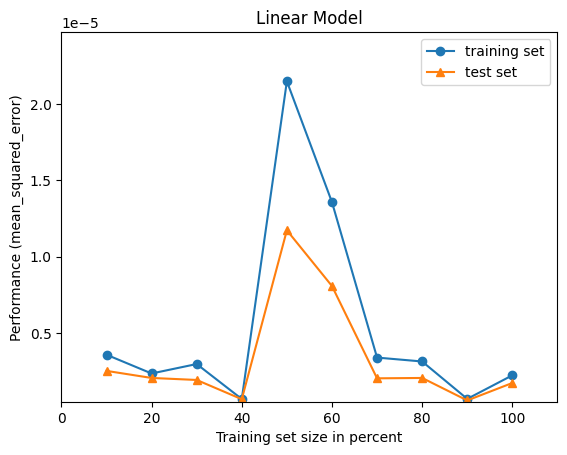

In [39]:
plot_curves(X_train,X_test,y_train,y_test,reg,"Linear Model")

### ANN Deep Learning

In [40]:
ANN = Sequential()                
ANN.add(Dense(units=10, input_dim=X_train.shape[1], 
                kernel_initializer='normal', activation='relu'))
ANN.add(Dense(1, kernel_initializer='normal'))
ANN.compile(loss='mean_squared_error', optimizer={'batch_size': 30, 'epochs': 20, 'optimizer_trial': 'rmsprop'}['optimizer_trial'])
ANN.fit(X_train, y_train,batch_size = int({'batch_size': 30, 'epochs': 20, 'optimizer_trial': 'rmsprop'}['batch_size']),
        epochs = int({'batch_size': 30, 'epochs': 20, 'optimizer_trial': 'rmsprop'}['epochs']), verbose=0)


ANN_predictions = ANN.predict(X_test)

ANN_predictions_org = TargetVarScalerFit.inverse_transform(ANN_predictions)

In [41]:
print("Accuracy for the ANN model is:", str(Accuracy_Score(y_test_orig, ANN_predictions_org)))

Accuracy for the ANN model is: 95.11563491821289


In [42]:
ANN1 = Sequential()                
ANN1.add(Dense(units=10, input_dim=X_train.shape[1], 
                kernel_initializer='normal', activation='relu'))
ANN1.add(Dense(1, kernel_initializer='normal'))
ANN1.compile(loss='mean_squared_error', optimizer={'batch_size': 30, 'epochs': 20, 'optimizer_trial': 'rmsprop'}['optimizer_trial'])

10942/10942 [==============================] - 8s 690us/step - loss: 34414880.0000


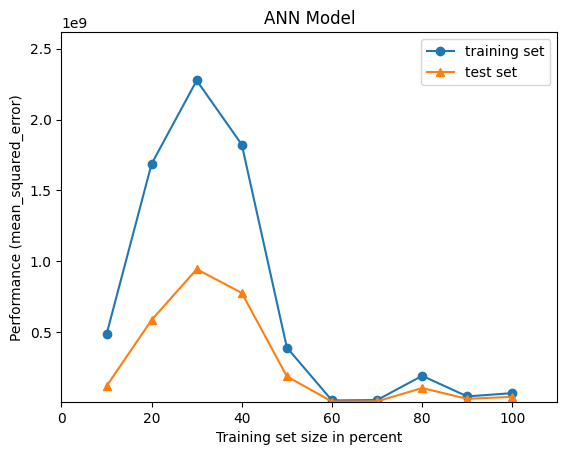

In [43]:
plot_curves(X_train,X_test,y_train,y_test,ANN1,"ANN Model")